# Fetch and export SNOTEL sites and daily time series data
2/29/2020

In [18]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
##USER INPUTS## - most of this can be read directly from the .ctl file or the .par file 
#-> need to read in text file
#start date
st = "2000-10-01"
#end date
ed = "2020-09-29"


#Snotel bounding box
Bbox = {
    'latmax' : 45.4562,
    'latmin' : 44.8004,
    'lonmax': -121.6515,
    'lonmin': -122.6089,}

# Snotel projection
stn_proj = 'epsg:4326' #WGS84
#model projection
mod_proj = 'epsg:32612' #UTM zone 12N

# Use ulmo to get SNOTEL station metadata within bounding box
## Get SNOTEL metadata over modeling domain

In [20]:
#function to extract data
def sites_asgdf(ulmo_getsites, crs=stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [21]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

In [22]:
# WaterML/WOF WSDL endpoint url 
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)

In [23]:
CSO_gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
CSO_gdf.drop(columns='index_right', inplace=True)
CSO_gdf.reset_index(drop=True, inplace=True)
#CSO_gdf.index = CSO_gdf['code']

#add columns with projected coordinates 
CSO_proj = CSO_gdf.to_crs(mod_proj)
CSO_gdf['easting'] = CSO_proj.geometry.x
CSO_gdf['northing'] = CSO_proj.geometry.y

CSO_gdf.head()

,code,longitude,latitude,name,elevation_m,geometry,easting,northing
0,351_OR_SNTL,-121.856049,45.428699,Blazed Alder,1112.52001953125,POINT (-121.85605 45.42870),-349122.260934,5.088226e+06
1,398_OR_SNTL,-121.754433,45.096581,Clackamas Lake,1036.3199462890625,POINT (-121.75443 45.09658),-346153.306893,5.050260e+06
2,401_OR_SNTL,-121.691597,45.188320,Clear Lake,1161.2879638671875,POINT (-121.69160 45.18832),-339846.412006,5.059786e+06
3,1029_OR_SNTL,-122.050003,44.816669,Epa Metolius,917.447998046875,POINT (-122.05000 44.81667),-373695.245509,5.022342e+06
4,651_OR_SNTL,-121.715797,45.320969,Mt Hood Test Site,1636.7760009765625,POINT (-121.71580 45.32097),-339766.890081,5.074773e+06


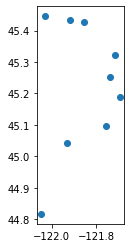

In [24]:
CSO_gdf.plot();

## Get SNOTEL SWE data in domain over time period of interest

In [25]:
#Emilio code

def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [26]:
stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in CSO_gdf.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        stn_swe[sitecode] = swe.value
    except:
        print(sitecode, 'has no data')
        stn_swe[sitecode] = np.nan

351_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29
398_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29
401_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29
1029_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29


Unable to fetch SNOTEL:WTEQ_D
1029_OR_SNTL has no data
651_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29
655_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29
687_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29
925_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29
1007_OR_SNTL SNOTEL:WTEQ_D 2000-10-01 2020-09-29


Unable to fetch SNOTEL:WTEQ_D
1007_OR_SNTL has no data


In [27]:
stn_swe.head()

,351_OR_SNTL,398_OR_SNTL,401_OR_SNTL,1029_OR_SNTL,651_OR_SNTL,655_OR_SNTL,687_OR_SNTL,925_OR_SNTL,1007_OR_SNTL
2000-10-01,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-02,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-03,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-04,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-05,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [28]:
#convert SNOTEL units[in] to SnowModel units [m]
for sitecode in CSO_gdf.code:
    # overwrite the original values (no use for the original values in inches)
    stn_swe[sitecode] = 0.0254 * stn_swe[sitecode]

stn_swe.head()

,351_OR_SNTL,398_OR_SNTL,401_OR_SNTL,1029_OR_SNTL,651_OR_SNTL,655_OR_SNTL,687_OR_SNTL,925_OR_SNTL,1007_OR_SNTL
2000-10-01,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-02,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-03,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-04,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2000-10-05,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


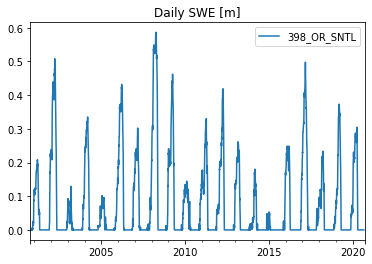

In [30]:
stn_swe.plot(y='398_OR_SNTL', title='Daily SWE [m]');

## Export the sites and daily time series to files, for reuse
- CSO_gdf to GeoJSON
- stn_swe to csv or parquet

**Note:** Sometimes the statement below produces this warning:
```
CSO_SNOTEL_sites.geojson: No such file or directory 
driver GeoJSON does not support creation option ENCODING
```

Ignore it. The GeoJSON file is still written out without issues.

In [34]:
CSO_gdf.to_file('ClackamasLake_Snotel_SWE', driver='GeoJSON')

In [35]:
len(stn_swe)

7304

In [36]:
# The file that's written is tiny, only 0.5 MB
stn_swe.to_csv('ClackamasLake_Snotel_SWE.csv')